Used laplace Variance as my first approach Since:
1)The Laplacian emphasizes areas where pixel intensity changes significantly (edges between objects and background).
2)In sharp images, edges are distinct, so the Laplacian output has high values (strong edges).
3)In blurry images, edges are smoothed, so the Laplacian output has lower values.

**Computed metrics :** Accuracy on test set , Precision , Recall , F1 score and most importantly confusion matrix which gave me insights.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Blurry images: 1694
Sharp images: 2224
Training set: 3134 images
Test set: 784 images
Threshold 20: Train Accuracy 0.7463
Threshold 25: Train Accuracy 0.7636
Threshold 50: Train Accuracy 0.7853
Threshold 100: Train Accuracy 0.7387
Threshold 125: Train Accuracy 0.7023
Threshold 150: Train Accuracy 0.6777
Threshold 175: Train Accuracy 0.6532
Threshold 200: Train Accuracy 0.6302
Best Threshold: 50 with Train Accuracy: 0.7853
Test Metrics: Accuracy 0.7781, Precision 0.7818, Recall 0.6916, F1 0.7339


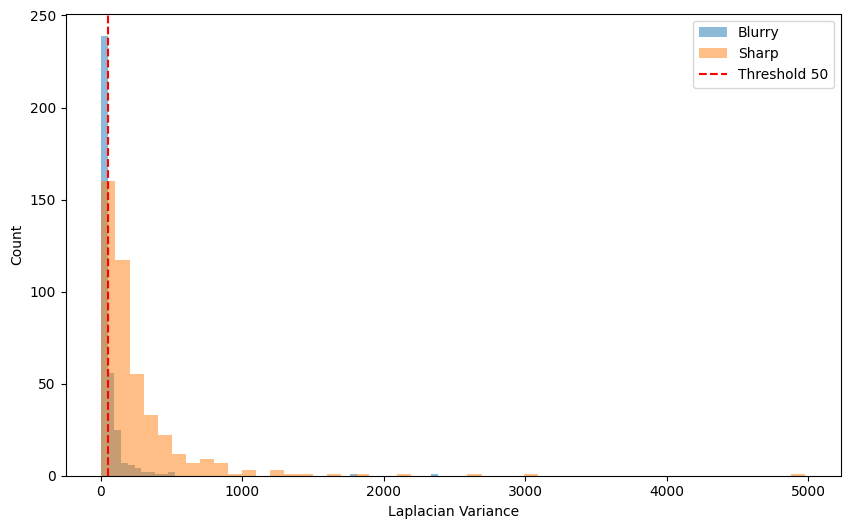

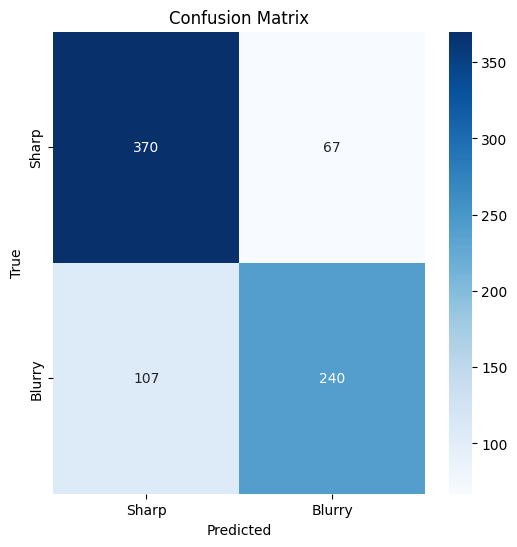

In [ ]:
from google.colab import drive
import cv2
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/blur_data'
blur_dir = os.path.join(dataset_path, 'blur')
sharp_dir = os.path.join(dataset_path, 'sharp')
output_dir = os.path.join(dataset_path, 'output')
os.makedirs(output_dir, exist_ok=True)

# Here I verified the folders
if not os.path.exists(blur_dir) or not os.path.exists(sharp_dir):
    raise FileNotFoundError(f"Check folder paths: {blur_dir}, {sharp_dir}")

def is_blurry(image_path, threshold=100):
    try:
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Cannot load image: {image_path}")
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        variance = laplacian.var()
        return 1 if variance < threshold else 0, variance  # 1 = blurry, 0 = sharp
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

# Loading dataset based on format of the image
image_paths = [(os.path.join(blur_dir, f), 1) for f in os.listdir(blur_dir) if f.endswith(('.jpg', '.png', '.jpeg'))] + \
              [(os.path.join(sharp_dir, f), 0) for f in os.listdir(sharp_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

print(f"Blurry images: {len([f for f in os.listdir(blur_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])}")
print(f"Sharp images: {len([f for f in os.listdir(sharp_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])}")

# Spliting my data into train and test
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, [label for _, label in image_paths], test_size=0.2, random_state=42) #taking 20 percent of the images for testing
print(f"Training set: {len(train_paths)} images")
print(f"Test set: {len(test_paths)} images")

# Tuning threshold on training set
thresholds = [20,25,50, 100, 125, 150, 175, 200]
best_threshold, best_accuracy = 0, 0
train_variances = []
valid_train_labels = []
for path, label in train_paths:
    pred, var = is_blurry(path)
    if var is not None:
        train_variances.append(var)
        valid_train_labels.append(label)

for t in thresholds:
    train_preds = [1 if v < t else 0 for v in train_variances]
    acc = accuracy_score(valid_train_labels, train_preds)
    print(f"Threshold {t}: Train Accuracy {acc:.4f}")
    if acc > best_accuracy:
        best_accuracy = acc
        best_threshold = t

print(f"Best Threshold: {best_threshold} with Train Accuracy: {best_accuracy:.4f}")

# Evaluating here on test set
test_preds, test_variances = [], []
valid_test_labels = []
misclassified = []
for (path, label), _ in zip(test_paths, range(len(test_paths))):
    pred, var = is_blurry(path, best_threshold)
    if pred is not None:
        test_preds.append(pred)
        test_variances.append(var)
        valid_test_labels.append(label)
        if pred != label:
            misclassified.append((path, label, pred, var))

# Computed all the required metrics
accuracy = accuracy_score(valid_test_labels, test_preds)
precision = precision_score(valid_test_labels, test_preds)
recall = recall_score(valid_test_labels, test_preds)
f1 = f1_score(valid_test_labels, test_preds)
print(f"Test Metrics: Accuracy {accuracy:.4f}, Precision {precision:.4f}, Recall {recall:.4f}, F1 {f1:.4f}")

# Save results and misclassifications to check further
with open(os.path.join(output_dir, 'results.txt'), 'w') as f:
    f.write(f"Best Threshold: {best_threshold}\n")
    f.write(f"Test Metrics: Accuracy {accuracy:.4f}, Precision {precision:.4f}, Recall {recall:.4f}, F1 {f1:.4f}\n")
    f.write(f"False Negatives (Blurry as Sharp): {sum(1 for _, t, p, _ in misclassified if t == 1 and p == 0)}\n")
    f.write("\nMisclassified Images (path, true label, predicted label, variance):\n")
    for path, true, pred, var in misclassified[:20]:
        f.write(f"{path}: True={true}, Pred={pred}, Variance={var:.2f}\n")

# Visualize and save variance distribution
plt.figure(figsize=(10, 6))
blurry_vars = [v for (p, l), v in zip(test_paths, test_variances) if l == 1]
sharp_vars = [v for (p, l), v in zip(test_paths, test_variances) if l == 0]
plt.hist(blurry_vars, bins=50, alpha=0.5, label='Blurry')
plt.hist(sharp_vars, bins=50, alpha=0.5, label='Sharp')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Threshold {best_threshold}')
plt.xlabel('Laplacian Variance')
plt.ylabel('Count')
plt.legend()
plt.savefig(os.path.join(output_dir, 'variance_distribution.png'))
plt.show()

# Visualized and save confusion matrix
cm = confusion_matrix(valid_test_labels, test_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sharp', 'Blurry'], yticklabels=['Sharp', 'Blurry'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()



Limitations : Motion blur as it comprises of directional edges which increases the variance of the images , causing misclassification as sharp.